In [55]:
%load_ext autoreload

In [107]:
%autoreload 2
import pickle
import json
import pandas as pd
# this category_encoders package is not part of the
# sklearn core packages, it is a 3rd party but makes
# our lives a lot easier because it can deal with encoding
# strings whereas sklearn's OneHotEncoder cannot
import category_encoders
from sklearn.preprocessing import Imputer, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
import numpy as np
from utils import *
%matplotlib inline
import matplotlib.pyplot as plt

# Preserving your model

In this learning unit you will learn how to preserve your model so that
the value it generates can be used in a separate process or program than the
one in which it was fitted. There are a few different ways to do this
but for this hackathon we will be using a few tools:

1. pickle from python core
1. pipelines from scikit

## The journey

### Train
We are going to first train a model on the classic titanic dataset. We will use
this one because it has categorical, numeric, and missings in both types.

### Serialize
Once the model has been trained as part of a pipeline, we will [serialize](https://en.wikipedia.org/wiki/Serialization)
it using the [pickle](https://docs.python.org/3/library/pickle.html) package
that is found in python's core.

### Predict on new data
After we are confident we can retrieve the pickled model from disk, we will
show how to prepare a brand new observation for prediction with the model.

Let's get started! We're not going to spend much time preparing the dataset or working on model performance
because it's not the focus of this learning unit. So let's power through the first few steps!

In [2]:
# read original dataset from disk and take a look at it
X = pd.read_csv('data/X_train.csv')
X.head()

,m_or_f,person_attributes,seat,other_person_location,other_factor_1,other_factor_2,other_factor_3,age_in_years
0,m,driving,front_left,NaN,NaN,NaN,NaN,50
1,m,on_bike,not_in_vehicle,in_unmarked_intersection,pedestrial_in_middle_of_street,NaN,NaN,42
2,f,driving,front_left,NaN,NaN,NaN,NaN,42
3,f,passenger,front_right,NaN,NaN,NaN,NaN,52
4,m,driving,front_left,NaN,NaN,NaN,NaN,45


In [231]:
df[~df.other_person_location.isnull()].label.value_counts()

1    1279
0      25
Name: label, dtype: int64

# y = pd.read_csv('data/y_train.csv',names=['label'])

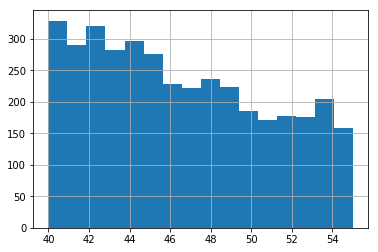

In [250]:
df[df.label == 0].age_in_years.hist(bins=16)

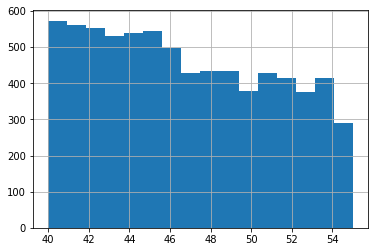

In [252]:
df[df.label == 1].age_in_years.hist(bins=16)

In [98]:
# now let's split it into X_train and y_train
y_true = df[df.label == 1]
y_false = df[df.label == 0]

In [99]:
df_2 = pd.concat([y_true.sample(frac=0.3),y_false])
X = df.drop(columns='label')
y = df['label']

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [205]:
with open('seat_passeger.tex','w') as tf:
    tf.write(X[X.person_attributes == 'passenger'].seat.value_counts().to_latex(escape=False))



## Let's build the pipeline

Okay, the next bit of necessary code isn't very much at all but
is very dense. So let's take things one at a time to understand
the motivation.

We'll begin with just the model itself - a logistic regression
and see what happens.

We know this game - scikit classifiers don't know how to deal
with non-numerical data. Since we already know about pipelines,
let's try to put together a pipeline that has a OneHotEncoder
in an attempt to deal with the non-numeric data.

In [224]:
pipeline = make_pipeline(
    LowerCase(),
    DropUnusefull(),
    category_encoders.OneHotEncoder(handle_unknown='impute',
                                   drop_invariant = True),
    #Imputer(strategy='mean'),
    #XGBClassifier()
)

In [225]:
X_train_transform = pipeline.fit_transform(X_train)

In [229]:
X_train_transform.oth

False    7903
True     1035
Name: other_person_info, dtype: int64

In [187]:
X_train[X_train.person_attributes == 'on_bike'].seat.value_counts()

not_in_vehicle    131
Name: seat, dtype: int64

In [218]:
pipeline.fit(X_train, y_train.values.reshape(-1,1))

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(memory=None,
     steps=[('lowercase', LowerCase()), ('dropunusefull', DropUnusefull()), ('onehotencoder', OneHotEncoder(cols=['person_attributes'], drop_invariant=True,
       handle_unknown='impute', impute_missing=True, return_df=True,
       verbose=0)), ('imputer', Imputer(axis=0, copy=True, missing_values='NaN'...
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1))])

In [219]:
roc_auc_score(y_test,pipeline.predict_proba(X_test)[:,1])

0.6143689429953871

In [149]:
fpr, tpr, _ = roc_curve(y_test, pipeline.predict_proba(X_test)[:,1])

In [37]:
with open('columns.json', 'w') as fh:
    json.dump(X_train.columns.tolist(), fh)

In [38]:
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train.dtypes, fh)

In [39]:
from sklearn.externals import joblib
joblib.dump(pipeline, 'pipeline.pickle') 

['pipeline.pickle']